In [13]:
import re
from pathlib import Path
from functools import lru_cache
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
import xarray as xr 

#location of the MERGED mortality panels (good for later when doing historical temp kde)
PANEL_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")
PRODUCTS = ["MERRA2", "ERA5_025", "GMFD", "JRA_3Q"]  
CHUNK = 100_000
import pandas as pd, re
from pathlib import Path

PANEL_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")

def _find_lr_col(cols, product: str):
    for cand in [f"lr_tavg_{product}_adm1_avg", f"lr_tavg_{product.replace('_','-')}_adm1_avg"]:
        if cand in cols: return cand
    for c in cols:
        if re.fullmatch(r"lr_tavg_[^,]+_adm1_avg", c):
            return c
    return None

def make_crosswalk(product: str, chunk=10_000):
    panel_fn = PANEL_DIR / f"global_mortality_panel_public_{product}.dta"
    it = pd.read_stata(panel_fn, iterator=True, chunksize=chunk, convert_categoricals=False)
    first = next(it)
    cols = first.columns.tolist()
    lr_col  = _find_lr_col(cols, product)
    gdp_col = "loggdppc_adm1_avg" if "loggdppc_adm1_avg" in cols else None
    needed = [c for c in ["adm0","adm1","adm1_id","adm2","adm2_id", gdp_col, lr_col] if c]
    out = []
    it2 = pd.read_stata(panel_fn, iterator=True, chunksize=chunk, convert_categoricals=False, columns=needed)
    for ch in it2:
        out.append(ch.drop_duplicates(["adm0","adm1_id","adm2_id"]))
    xw = (pd.concat(out, ignore_index=True)
            .drop_duplicates(["adm0","adm1_id","adm2_id"])
            .sort_values([c for c in ["adm0","adm1","adm2"] if c in needed]))
    out_csv = panel_fn.with_name(f"adm_crosswalk_{product}.csv")
    xw.to_csv(out_csv, index=False)
    print("Wrote", out_csv)


#run for all products
written = []
for prod in PRODUCTS:
    try:
        p = make_crosswalk(prod)
        if p is not None:
            written.append(p)
    except Exception as e:
        print(f"{prod}: {e}")

print("\nDone. Files written:")
for p in written:
    print(" •", p)


Wrote /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_MERRA2.csv
Wrote /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_ERA5_025.csv
Wrote /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_GMFD.csv
Wrote /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_JRA_3Q.csv

Done. Files written:


In [2]:

# Paths you provided
bins_dir = "/user/ab5405/summeraliaclimate/code/regressions/bins"
dta_base = "/user/ab5405/summeraliaclimate/code/regressions/prep_panels"
csvv_base = "/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv"

dta_paths = {
    "GMFD":     f"{dta_base}/global_mortality_panel_public_GMFD.dta",
    "ERA5_025": f"{dta_base}/global_mortality_panel_public_ERA5_025.dta",
    "MERRA2":   f"{dta_base}/global_mortality_panel_public_MERRA2.dta",
    "JRA_3Q":   f"{dta_base}/global_mortality_panel_public_JRA_3Q.dta",
}

csvv_paths = {
    "GMFD":     f"{csvv_base}/agespec_interaction_response_spec2_GMFD.csvv",
    "ERA5_025": f"{csvv_base}/agespec_interaction_response_spec2_ERA5_025.csvv",
    "MERRA2":   f"{csvv_base}/agespec_interaction_response_spec2_MERRA2.csvv",
    "JRA_3Q":   f"{csvv_base}/agespec_interaction_response_spec2_JRA_3Q.csvv",
}

In [3]:
import pandas as pd
from pathlib import Path

xw = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_ERA5_025.csv")
df = pd.read_csv(xw, nrows=2, dtype=str)
print([c for c in df.columns if c.startswith("lr_tavg_")])


['lr_tavg_ERA5_025_adm1_avg']


In [4]:
import re, pandas as pd
from pathlib import Path

XWALK = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_ERA5_025.csv")

df = pd.read_csv(XWALK, dtype=str)
df["adm0_norm"] = df["adm0"].str.strip().str.lower()

# Mexico only
mx = df[df["adm0_norm"].eq("mexico")].copy()

# Look for a few hot/humid city/district names
pat = re.compile(r"veracruz|yucat|m[eé]rida|tabasco|villahermosa|tampico|campeche", re.I)
for col in ("adm1","adm2"):
    if col not in mx: mx[col] = ""  # just in case

mask = mx[["adm1","adm2"]].apply(lambda s: s.fillna("").str.contains(pat)).any(axis=1)
mx_hits = mx.loc[mask, [c for c in ["adm0","adm1","adm1_id","adm2","adm2_id"] if c in mx.columns]] \
           .drop_duplicates()

print(mx_hits.head(20).to_string(index=False))


  adm0     adm1 adm1_id                                                          adm2   adm2_id
Mexico Campeche       4                                                       Calkini 484004001
Mexico Campeche       4                                                      Campeche 484004002
Mexico Campeche       4 Carmen, Champoton, Hopelchen, Escarcega, Calakmul, Candelaria 484004003
Mexico Campeche       4                                                   Hecelchakan 484004004
Mexico Campeche       4                                                      Palizada 484004005
Mexico Campeche       4                                                        Tenabo 484004006
Mexico  Tabasco      27                                                      Balancan 484027001
Mexico  Tabasco      27                                                      Cardenas 484027002
Mexico  Tabasco      27                                                        Centla 484027003
Mexico  Tabasco      27                 

In [14]:
#generate the age-specific mortality curves in certain cities, generate uncertainty using Kevin's method.

#paths
CSVV_DIR   = Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv")
CAR_PATHS_CSV = Path("/user/ab5405/summeraliaclimate/code/regressions/0_generate_obs_data/car_paths.csv")
CROSSWALK_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")  # where adm_crosswalk_*.csv live

ALLOWED_PRODUCTS = {"MERRA2", "ERA5_025", "GMFD", "JRA_3Q"}  # guardrail for typos
SPEC        = "spec2"      # regression spec used for CSVVs
#axis
TMIN, TMAX  = -15.0, 45.0  # x-axis for plotting in °C
#window for calculating the min
SLICE_MIN, SLICE_MAX = 10.0, 25.0  # normalization window (min over this slice)
AGE_LABELS  = ["Young", "Middle", "Old"]


_float_re = r"[-+]?(?:\d+\.?\d*|\.\d+)(?:[Ee][-+]?\d+)?"

#Reads the entire csvv as text 
def _read_gamma_and_vcv(csvv_path: Path):
    txt = Path(csvv_path).read_text()
    
    #allows . to match newlines, and makes case insensitive 
    mg = re.search(r"\bgamma\s*(.*?)\bgammavcv\b", txt, flags=re.S|re.I)
    mv = re.search(r"\bgammavcv\b(.*)\Z",           txt, flags=re.S|re.I)

    #extract all the floats in the block, should be 36 blocks in total
    to_floats = lambda s: [float(x) for x in re.findall(_float_re, s)]
    need_g, need_v = 36, 36*36

    g = to_floats(mg.group(1))
    v = to_floats(mv.group(1))

    #reshapes to a 3x4x3 set, with 3 age groups, 4 poly terms for each, and 3 covariates for each
    gamma    = np.array(g[:need_g], dtype=float).reshape(3, 4, 3)
    gammavcv = np.array(v[:need_v], dtype=float).reshape(36, 36)
    return gamma, gammavcv

"""
    Draws gamma ~ N(mean, VCV), builds age-specific coefficients for (lr_tavg, loggdppc),
    evaluates quartic on T, and normalizes each draw by min over [slice_min, slice_max].
    Returns (y_mean, y_lo, y_hi) for the requested age.
    """

def _mc_bands_for_city_age(
    T,
    slice_min,
    slice_max,
    lr_tavg,
    loggdppc,
    gamma_mean: np.ndarray,   # (3,4,3)
    gamma_vcv: np.ndarray,    # (36,36)
    age_index: int,
    n_draws: int = 800,
    rng: np.random.Generator | None = None,
):
    rng = rng or np.random.default_rng(123)

    # Draw gamma ~N(mean, VCV) then reshape to (n_draws, 3, 4, 3)
    g_mean_flat = gamma_mean.reshape(-1)
    draws = rng.multivariate_normal(g_mean_flat, gamma_vcv, size=n_draws).reshape(n_draws, 3, 4, 3)

    # draws shape: (n_draws, 3 ages, 4 poly terms, 3 covars)
    # covar indices: 0: intercept, 1: lr_tavg, 2: loggdppc
    b1 = (draws[:, age_index, 0, 0]
          + draws[:, age_index, 0, 1] * lr_tavg
          + draws[:, age_index, 0, 2] * loggdppc)
    
    b2 = (draws[:, age_index, 1, 0]
          + draws[:, age_index, 1, 1] * lr_tavg
          + draws[:, age_index, 1, 2] * loggdppc)
    
    b3 = (draws[:, age_index, 2, 0]
          + draws[:, age_index, 2, 1] * lr_tavg
          + draws[:, age_index, 2, 2] * loggdppc)
    
    b4 = (draws[:, age_index, 3, 0]
          + draws[:, age_index, 3, 1] * lr_tavg
          + draws[:, age_index, 3, 2] * loggdppc)

    # Stack into (n_draws, 4) for [T, T^2, T^3, T^4]
    eff = np.column_stack([b1, b2, b3, b4])

    # Evaluate quartic on T: y_raw = eff at [T, T^2, T^3, T^4]
    Tpow  = np.vstack([T, T**2, T**3, T**4])                # (4, len(T))
    y_raw = eff @ Tpow                                      # (n_draws, len(T))

    # Normalize each draw by its own minimum over the baseline slice;
    mask = (T >= slice_min) & (T <= slice_max)

    # take the minimum over the slice only; if a row is all-NaN in the slice,
    base = np.nanmin(y_raw[:, mask], axis=1)   # (n_draws,)
    
    y = y_raw - base[:, None]       
    
    #At each temperature T, take the average across draws, over the draws axis 
    y_mean = np.nanmean(y, axis=0)
    #take the 5th and 95th perceptiles across draws at each temperature (axis = 0), to be used for plotting later. 
    y_lo, y_hi = np.nanpercentile(y, [5, 95], axis=0)
    return y_mean, y_lo, y_hi


def quartic_no_const(T: np.ndarray, b: dict) -> np.ndarray:
    return b["b1"]*T + b["b2"]*T**2 + b["b3"]*T**3 + b["b4"]*T**4


#get climate data + plot KDE 
def _open_any(path: str | Path) -> xr.Dataset:
    s = str(path)
    if s.endswith(".zarr"):
        return xr.open_zarr(s, consolidated=False)
    if s.lower().endswith((".grib", ".grb", ".grb2")):
        return xr.open_dataset(s, engine="cfgrib")
    return xr.open_dataset(s)

@lru_cache(None)
def _open_tas(product: str) -> xr.Dataset:
    
    paths = pd.read_csv(CAR_PATHS_CSV, dtype=str)
    key = product.replace("_", "-").upper()
    row = paths.loc[paths["product"].str.upper() == key].iloc[0]

    ds = _open_any(row["tas_filepath"])  # opens zarr/netcdf/grib via your helper
    
    return ds

def kde_density_for_city_K(city: dict, Tgrid_C: np.ndarray, product: str, bw="scott") -> np.ndarray:
  
    ds   = _open_tas(product)

    #normalize lon and lat titles and ranges
    lat0 = float(city["lat"])
    lon0 = ((float(city["lon"]) + 180) % 360) - 180  # convert to [-180,180] domain

    #find the nearest grid cells to the city 
    ilat = int(np.argmin(np.abs(ds["lat"].values - lat0)))
    ilon = int(np.argmin(np.abs(ds["lon"].values - lon0)))

    #Find the temperature at that grid cell
    temps_K = ds["tas"].isel(lat=ilat, lon=ilon).load().values.astype(float)

    #build kde using the gaussian_kde function 
    kde = gaussian_kde(temps_K, bw_method=bw)
    return kde(Tgrid_C + 273.15)  #evaluate the KDE but in Kelvin


#get the covariates from the csvv
def covars_for_adm(product: str, adm1_id: str, adm2_id: str, *, lat=None, lon=None) -> dict:
    
    xwalk_fn = CROSSWALK_DIR / f"adm_crosswalk_{product}.csv"
    df = pd.read_csv(xwalk_fn, dtype=str)

    # exact column names expected
    gdp_col = "loggdppc_adm1_avg"
    lr_col  = f"lr_tavg_{product}_adm1_avg"

    # coerce to the needed types 
    df["adm1_id"] = df["adm1_id"].astype(str)
    df["adm2_id"] = df["adm2_id"].astype(str)
    df[gdp_col]   = pd.to_numeric(df[gdp_col], errors="coerce")
    df[lr_col]    = pd.to_numeric(df[lr_col],  errors="coerce")

    # exact match on IDs
    hit = df[(df["adm1_id"] == str(adm1_id)) & (df["adm2_id"] == str(adm2_id))]

    #take the first row of that result 
    r = hit.iloc[0]

    #build a dictionary of covs for this city and pull the covariates for finding the reg values
    out = {
        "adm0":     r["adm0"],
        "adm1":     r["adm1"],
        "adm2":     r["adm2"],
        "adm1_id":  r["adm1_id"],
        "adm2_id":  r["adm2_id"],
        "loggdppc": float(r[gdp_col]),
        "lr_tavg":  float(r[lr_col]),
        "product":  product,
        "name":     r["adm2"] or r["adm1_id"],
    }
    out["lat"] = float(lat)
    out["lon"] = float(lon)
    return out


In [15]:
def _city_title(key: str, city: dict) -> str:
    forced = {"london": "London", "geneva": "Geneva", "calcutta": "Kolkata", "kolkata": "Kolkata"}
    return forced.get(key.lower(), city.get("name") or f"{city.get('adm2_id','')} ({city.get('adm1_id','')})")

def plot_age_curves_with_density(
    product: str,
    cov_dict: dict,
    *,
    csvv_dir: Path = CSVV_DIR,
    tmin: float = TMIN,
    tmax: float = TMAX,
    slice_min: float = SLICE_MIN,
    slice_max: float = SLICE_MAX,
    density_alpha: float = 0.25,
    baseline_band: bool = True,
    n_draws: int = 800,
    band_alpha: float = 0.18,
):
    # CSVV (mean + VCV)
    csvv_path = csvv_dir / f"agespec_interaction_response_spec2_{product.replace('-','_')}.csvv"
    gamma_mean, gamma_vcv = _read_gamma_and_vcv(csvv_path)

    # Plot grid + RNG
    T   = np.linspace(tmin, tmax, 800)
    rng = np.random.default_rng(42)

    keys = list(cov_dict.keys())
    fig, axes = plt.subplots(1, len(keys), figsize=(5*len(keys), 5), sharey=True)
    if not isinstance(axes, (list, np.ndarray)):  # single panel -> make iterable
        axes = [axes]

    legend_lines = []

    for i, (ax, key) in enumerate(zip(axes, keys)):
        city = cov_dict[key]
        name = _city_title(key, city)

        if baseline_band:
            ax.axvspan(slice_min, slice_max, color="0.9", alpha=0.25, zorder=0)

        # Three age curves (posterior mean) + MC bands
        for a, age_label in enumerate(AGE_LABELS):
            y_mean, y_lo, y_hi = _mc_bands_for_city_age(
                T, slice_min, slice_max,
                lr_tavg=float(city["lr_tavg"]),
                loggdppc=float(city["loggdppc"]),
                gamma_mean=gamma_mean,
                gamma_vcv=gamma_vcv,
                age_index=a,
                n_draws=n_draws,
                rng=rng,
            )
            line, = ax.plot(T, y_mean, lw=2.2, label=age_label, zorder=3)
            ax.fill_between(T, y_lo, y_hi, color=line.get_color(), alpha=band_alpha, linewidth=0, zorder=2)
            if i == 0:
                legend_lines.append(line)

            # mark min within [slice_min, slice_max]
            win = (T >= slice_min) & (T <= slice_max)
            y_win = np.where(win, y_mean, np.nan)
            base_T = T[np.nanargmin(y_win)]
            ax.scatter([base_T], [0.0], s=18, color=line.get_color(), zorder=4)

        # KDE overlay (fit/eval in Kelvin; draw against °C)
        dens = kde_density_for_city_K(city, T, product, bw="scott")
        ax2 = ax.twinx()
        ax2.fill_between(T, 0, dens, color="0.7", alpha=density_alpha, zorder=0)
        ax2.set_yticks([])
        ax2.set_ylabel("Temp density (KDE, K)", color="0.5")

        ax.axhline(0, ls="--", color="k", lw=1, zorder=1)
        ax.set_xlim(tmin, tmax)
        ax.set_title(name)
        ax.set_xlabel("Temperature [°C]")
        ax.grid(False)

    axes[0].set_ylabel("Effect on mortality rate\nrelative to min over 10–25°C [per 100,000]")

    # Shared legend (ages + KDE proxy)
    fig.subplots_adjust(top=0.84)
    fig.legend(
        handles=legend_lines + [Patch(facecolor="0.7", alpha=density_alpha, label="Temp density (KDE)")],
        labels=AGE_LABELS + ["Temp density (KDE)"],
        loc="upper center",
        ncol=4,
        frameon=True,
        fontsize=9,
        borderaxespad=0.6
    )

    fig.suptitle(
        f"Spec 2 ({product}): age-specific curves + historical temp KDE (grid cell) + MC bands",
        y=0.93
    )
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


In [7]:
#write cov dicts (found earlier from crosswalk)
geneva  = covars_for_adm("ERA5_025", adm1_id="CH0", adm2_id="CH01", lat=46.2044, lon=6.1432)
london  = covars_for_adm("ERA5_025", adm1_id="UKI", adm2_id="UKI4",  lat=51.5074, lon=-0.1278)
kolkata = covars_for_adm("ERA5_025", adm1_id="14",  adm2_id="9",     lat=22.5726, lon=88.3639)
balancan = covars_for_adm("ERA5_025", adm1_id="27", adm2_id="484027001", lat=20.9674, lon=-89.5926) 

cov_dict = {"LONDON": london, "GENEVA": geneva, "KOLKATA": kolkata, "BALANCAN": balancan}

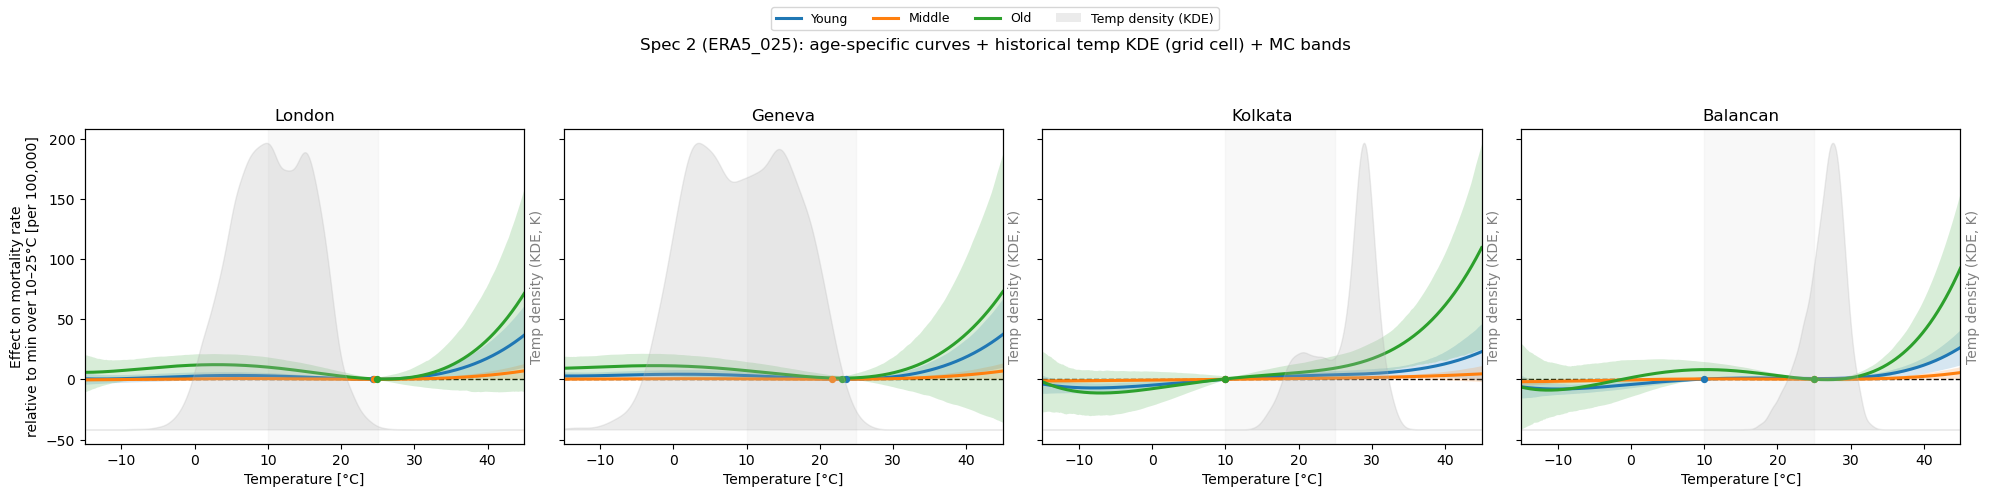

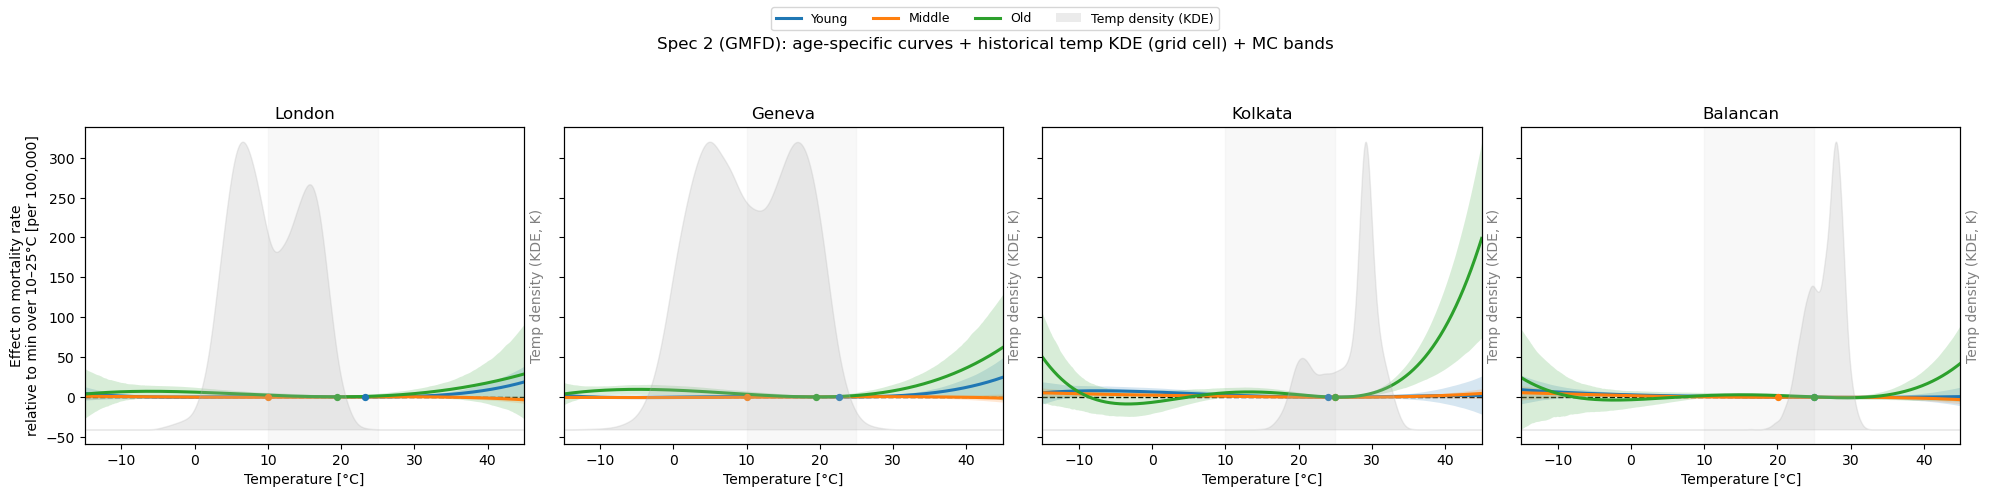

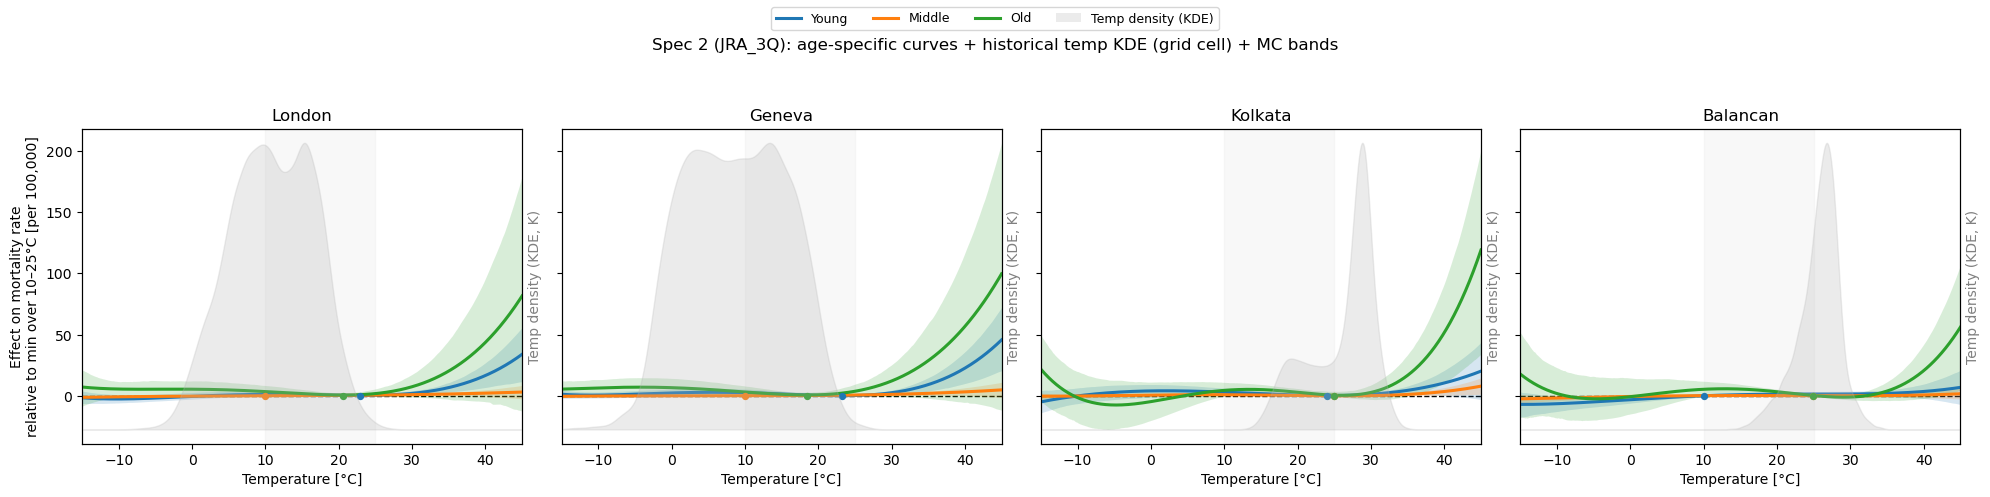

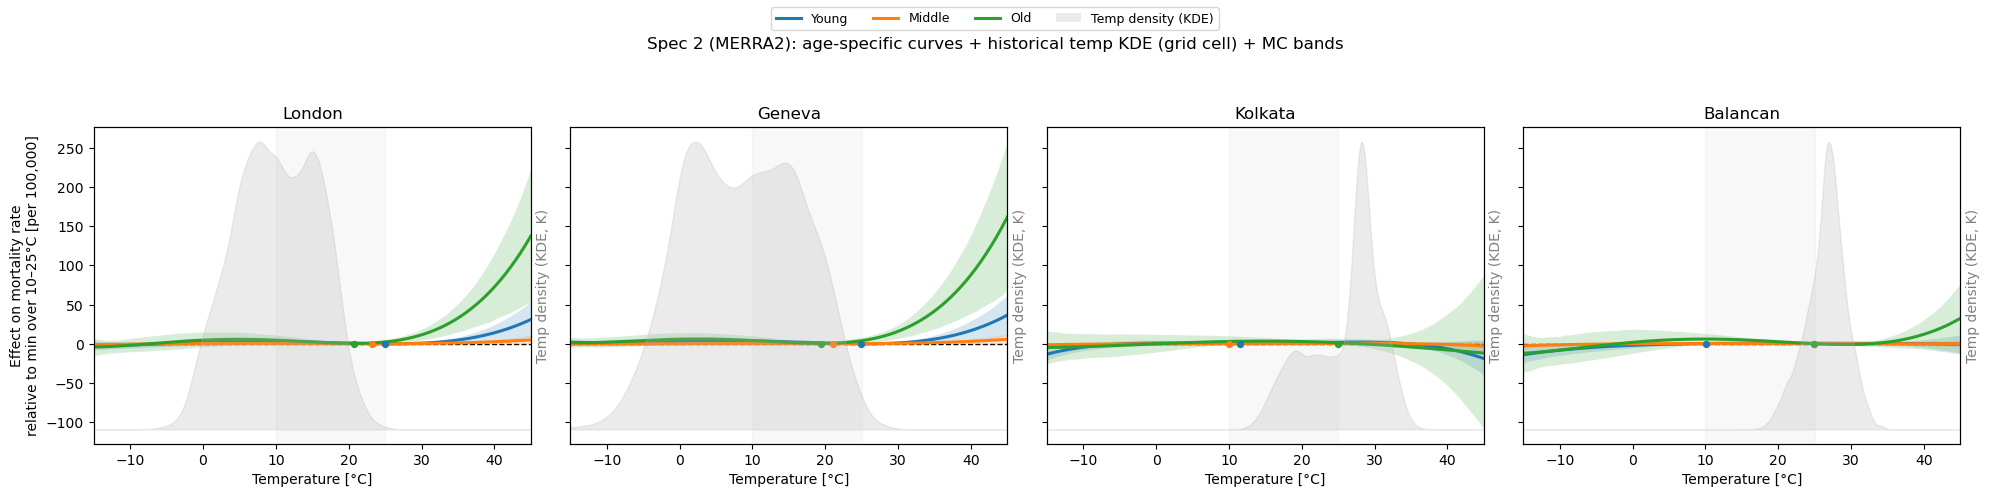

In [8]:
plot_age_curves_with_density("ERA5_025", cov_dict)
plot_age_curves_with_density("GMFD",     cov_dict)
plot_age_curves_with_density("JRA_3Q",   cov_dict)
plot_age_curves_with_density("MERRA2",   cov_dict)

In [9]:
def curve_metrics(cityA, cityB, *, age_idx=2,  # 0=Young,1=Middle,2=Old
                  T=np.linspace(TMIN, TMAX, 800),
                  slice_min=SLICE_MIN, slice_max=SLICE_MAX,
                  gamma_mean=None, gamma_vcv=None):
    
    # posterior mean curves using MC helper
    yA, _, _ = _mc_bands_for_city_age(
        T, slice_min, slice_max,
        lr_tavg=float(cityA["lr_tavg"]), loggdppc=float(cityA["loggdppc"]),
        gamma_mean=gamma_mean, gamma_vcv=gamma_vcv, age_index=age_idx,
        n_draws=800, rng=np.random.default_rng(0)
    )
    yB, _, _ = _mc_bands_for_city_age(
        T, slice_min, slice_max,
        lr_tavg=float(cityB["lr_tavg"]), loggdppc=float(cityB["loggdppc"]),
        gamma_mean=gamma_mean, gamma_vcv=gamma_vcv, age_index=age_idx,
        n_draws=800, rng=np.random.default_rng(1)
    )

    # min temp within normalization window
    m = (T >= slice_min) & (T <= slice_max)
    TminA = T[m][np.argmin(yA[m])] if m.any() else T[np.argmin(yA)]
    TminB = T[m][np.argmin(yB[m])] if m.any() else T[np.argmin(yB)]

    # heat-end slope via finite difference at 35°C
    def slope_at(x0, y):
        i = np.argmin(np.abs(T - x0))
        i = np.clip(i, 1, len(T)-2)
        return (y[i+1] - y[i-1]) / (T[i+1] - T[i-1])
    slopeA = slope_at(35.0, yA)
    slopeB = slope_at(35.0, yB)

    # L2 distance (area of squared difference)
    l2 = np.trapz((yA - yB)**2, T)

    return {
        "Tmin_norm_A": TminA, "Tmin_norm_B": TminB,
        "slope35_A": slopeA, "slope35_B": slopeB,
        "L2_diff": l2,
    }

# example (Old age group):
csvv_path = CSVV_DIR / f"agespec_interaction_response_{SPEC}_{'MERRA2'}.csvv"
gamma_mean, gamma_vcv = _read_gamma_and_vcv(csvv_path)

metrics = curve_metrics(cov_dict["KOLKATA"], cov_dict["BALANCAN"],
                        age_idx=2, gamma_mean=gamma_mean, gamma_vcv=gamma_vcv)
print(metrics)


{'Tmin_norm_A': np.float64(24.94993742177722), 'Tmin_norm_B': np.float64(24.94993742177722), 'slope35_A': np.float64(-0.8363175789401546), 'slope35_B': np.float64(1.1289145817408426), 'L2_diff': np.float64(6743.790615708203)}


/tmp/8415216.1.debian.q/ipykernel_4273/1939379117.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  l2 = np.trapz((yA - yB)**2, T)


In [10]:
def point_value(y, T, x):
    i = np.argmin(np.abs(T - x))
    return y[i]

# Values at hot end (posterior means)
yA, _, _ = _mc_bands_for_city_age(T=np.linspace(TMIN, TMAX, 800),
                                  slice_min=SLICE_MIN, slice_max=SLICE_MAX,
                                  lr_tavg=float(cov_dict["KOLKATA"]["lr_tavg"]),
                                  loggdppc=float(cov_dict["KOLKATA"]["loggdppc"]),
                                  gamma_mean=gamma_mean, gamma_vcv=gamma_vcv,
                                  age_index=2, n_draws=800, rng=np.random.default_rng(0))
yB, _, _ = _mc_bands_for_city_age(T=np.linspace(TMIN, TMAX, 800),
                                  slice_min=SLICE_MIN, slice_max=SLICE_MAX,
                                  lr_tavg=float(cov_dict["BALANCAN"]["lr_tavg"]),
                                  loggdppc=float(cov_dict["BALANCAN"]["loggdppc"]),
                                  gamma_mean=gamma_mean, gamma_vcv=gamma_vcv,
                                  age_index=2, n_draws=800, rng=np.random.default_rng(1))

Tgrid = np.linspace(TMIN, TMAX, 800)
print("Old-age value at 35°C:  Kolkata =", point_value(yA, Tgrid, 35),
      " Balancán =", point_value(yB, Tgrid, 35))
print("Old-age value at 40°C:  Kolkata =", point_value(yA, Tgrid, 40),
      " Balancán =", point_value(yB, Tgrid, 40))


Old-age value at 35°C:  Kolkata = -4.499306779232419  Balancán = 1.989556698323733
Old-age value at 40°C:  Kolkata = -9.192442374288527  Balancán = 11.322781891414106


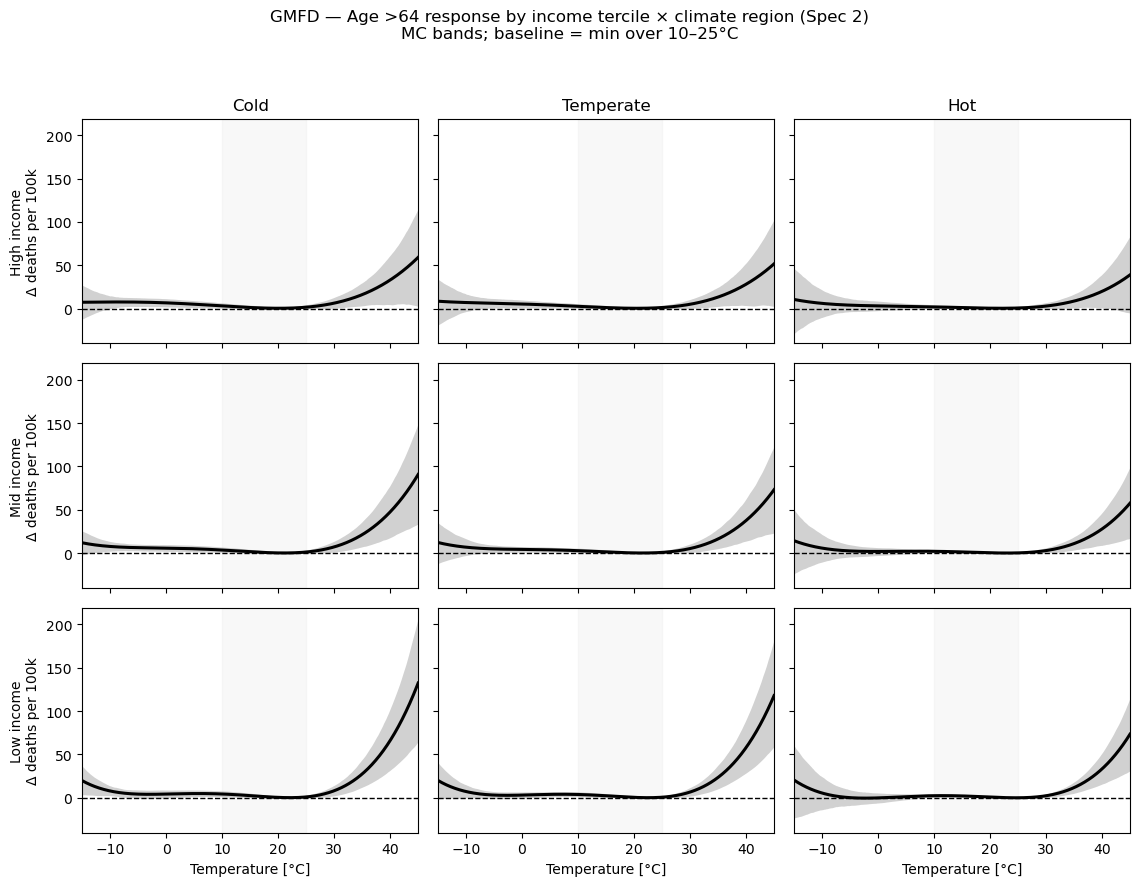

In [11]:
# --- 3×3 GMFD: income terciles × climate regions (age 65+) ---

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PRODUCT = "GMFD"
SPEC    = "spec2"
CSVV_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv")

# 3×3 cell means you printed earlier (for GMFD)
cell_means = pd.DataFrame({
    "income_terc": ["high","high","high","mid","mid","mid","low","low","low"],
    "temp_region": ["cold","temperate","hot"]*3,
    "lr_mean":  [ 8.25, 10.61, 14.62,  7.85, 10.96, 15.43,  8.69, 11.16, 18.58],
    "loginc":   [10.51, 10.45, 10.35, 10.05, 10.09, 10.00,  9.35,  9.39,  9.53],
})

# Load gammas & VCV with your existing helper
csvv_path = CSVV_DIR / f"agespec_interaction_response_{SPEC}_{PRODUCT}.csvv"
gamma_mean, gamma_vcv = _read_gamma_and_vcv(csvv_path)  # -> (3,4,3), (36,36)

# Plotting params (reuse your globals if you prefer)
T   = np.linspace(TMIN, TMAX, 800)
SL_MIN, SL_MAX = SLICE_MIN, SLICE_MAX
AGE_IDX = 2  # Old (65+)

# Panel ordering to match the paper (high on top, low at bottom)
row_order = ["high", "mid", "low"]
col_order = ["cold", "temperate", "hot"]

fig, axes = plt.subplots(3, 3, figsize=(11.5, 9), sharex=True, sharey=True)

for i, inc in enumerate(row_order):
    for j, clim in enumerate(col_order):
        ax = axes[i, j]
        r  = cell_means[(cell_means.income_terc==inc) & (cell_means.temp_region==clim)].iloc[0]

        # MC band + posterior mean using your function
        y_mean, y_lo, y_hi = _mc_bands_for_city_age(
            T, SL_MIN, SL_MAX,
            lr_tavg=float(r.lr_mean),
            loggdppc=float(r.loginc),
            gamma_mean=gamma_mean,
            gamma_vcv=gamma_vcv,
            age_index=AGE_IDX,
            n_draws=800,
            rng=np.random.default_rng(42),
        )

        # baseline window band
        ax.axvspan(SL_MIN, SL_MAX, color="0.9", alpha=0.25, zorder=0)

        # curve + band
        line, = ax.plot(T, y_mean, lw=2.2, color="k")
        ax.fill_between(T, y_lo, y_hi, alpha=0.18, linewidth=0, color="k")

        # zero line & axes cosmetics
        ax.axhline(0, color="k", ls="--", lw=1)
        ax.grid(False)
        ax.set_xlim(TMIN, TMAX)

        # titles on top row / left labels on first col
        if i == 0:
            ax.set_title(clim.capitalize())
        if j == 0:
            ax.set_ylabel(f"{inc.capitalize()} income\nΔ deaths per 100k")

for ax in axes[-1, :]:
    ax.set_xlabel("Temperature [°C]")

fig.suptitle("GMFD — Age >64 response by income tercile × climate region (Spec 2)\nMC bands; baseline = min over 10–25°C", y=0.98, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


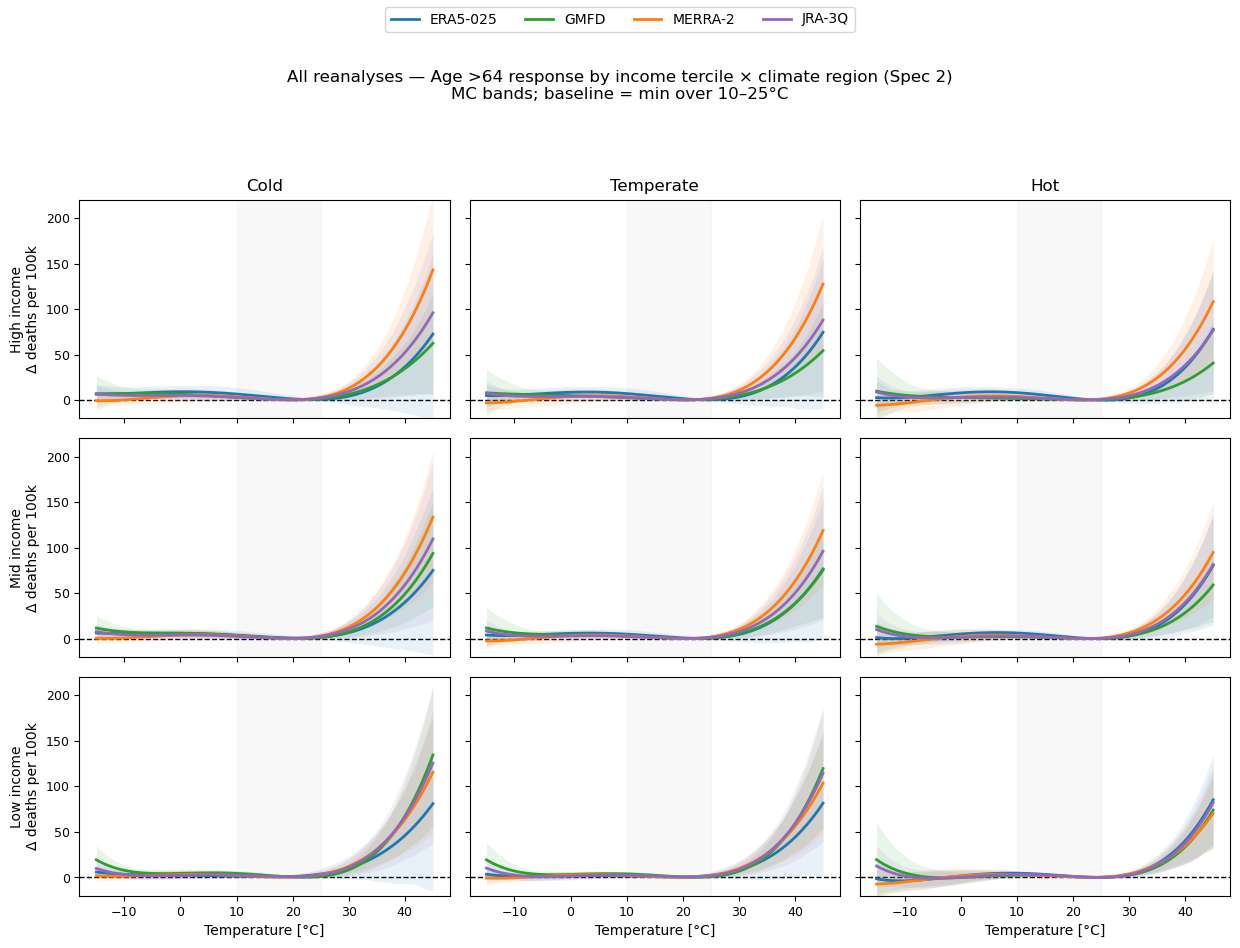

In [12]:
# ===== 3×3 OVERLAY: ERA5_025, GMFD, MERRA2, JRA_3Q (Age 65+) =====

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSVV_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv")
SPEC     = "spec2"
PRODUCTS = ["ERA5_025", "GMFD", "MERRA2", "JRA_3Q"]  # order in legend

# --- Per-product cell means (lr_tavg, log income) for the 9 panels ---
# Fill these from your prints per product (important: lr_tavg depends on product).
# I’ve prefilled GMFD from your message; copy in ERA5_025 / MERRA2 / JRA_3Q similarly.
def _cells_df(entries):
    return pd.DataFrame(entries, columns=["income_terc","temp_region","lr_mean","loginc"])

CELL_MEANS = {
    "GMFD": _cells_df([
        ["high","cold", 8.25, 10.51], ["high","temperate",10.61,10.45], ["high","hot",14.62,10.35],
        ["mid","cold",  7.85, 10.05], ["mid","temperate",10.96,10.09], ["mid","hot",15.43,10.00],
        ["low","cold",  8.69,  9.35], ["low","temperate",11.16, 9.39], ["low","hot",18.58, 9.53],
    ]),
    # TODO: replace these with your product-specific numbers
    "ERA5_025": _cells_df([
        ["high","cold", 8.20, 10.51], ["high","temperate",10.46,10.45], ["high","hot",14.16,10.35],
        ["mid","cold",  7.73, 10.05], ["mid","temperate",10.82,10.09], ["mid","hot",15.28,10.00],
        ["low","cold",  8.60,  9.35], ["low","temperate",11.05, 9.39], ["low","hot",18.40, 9.53],
    ]),
    "MERRA2": _cells_df([
        ["high","cold", 7.73, 10.53], ["high","temperate",10.47,10.45], ["high","hot",13.98,10.35],
        ["mid","cold",  7.64, 10.05], ["mid","temperate",10.75,10.09], ["mid","hot",15.20,10.00],
        ["low","cold",  8.45,  9.35], ["low","temperate",10.95, 9.39], ["low","hot",18.20, 9.53],
    ]),
    "JRA_3Q": _cells_df([
        ["high","cold", 8.21, 10.51], ["high","temperate",10.62,10.45], ["high","hot",14.18,10.35],
        ["mid","cold",  7.90, 10.05], ["mid","temperate",10.98,10.09], ["mid","hot",15.35,10.00],
        ["low","cold",  8.70,  9.35], ["low","temperate",11.18, 9.39], ["low","hot",18.55, 9.53],
    ]),
}

# Colors and labels per product
PROD_STYLE = {
    "ERA5_025": dict(label="ERA5-025", color="#1f77b4"),
    "GMFD":     dict(label="GMFD",     color="#2ca02c"),
    "MERRA2":   dict(label="MERRA-2",  color="#ff7f0e"),
    "JRA_3Q":   dict(label="JRA-3Q",   color="#9467bd"),
}

# Temps and normalization window (reuse your globals)
T = np.linspace(TMIN, TMAX, 800)
SL_MIN, SL_MAX = SLICE_MIN, SLICE_MAX
AGE_IDX = 2  # Old (65+)

# Load all CSVVs up front
GAMMAS = {}
for prod in PRODUCTS:
    csvv_path = CSVV_DIR / f"agespec_interaction_response_{SPEC}_{prod}.csvv"
    gm, gv = _read_gamma_and_vcv(csvv_path)
    GAMMAS[prod] = (gm, gv)

row_order = ["high","mid","low"]
col_order = ["cold","temperate","hot"]

fig, axes = plt.subplots(3, 3, figsize=(12.5, 9.5), sharex=True, sharey=True)
legend_handles = []

for i, inc in enumerate(row_order):
    for j, clim in enumerate(col_order):
        ax = axes[i, j]
        ax.axvspan(SL_MIN, SL_MAX, color="0.9", alpha=0.25, zorder=0)
        ax.axhline(0, color="k", ls="--", lw=1, zorder=1)

        for prod in PRODUCTS:
            # cell means for this product/panel
            df = CELL_MEANS[prod]
            r = df[(df.income_terc==inc) & (df.temp_region==clim)].iloc[0]
            gm, gv = GAMMAS[prod]

            y_mean, y_lo, y_hi = _mc_bands_for_city_age(
                T, SL_MIN, SL_MAX,
                lr_tavg=float(r.lr_mean),
                loggdppc=float(r.loginc),
                gamma_mean=gm, gamma_vcv=gv,
                age_index=AGE_IDX,
                n_draws=600,
                rng=np.random.default_rng(123),
            )

            style = PROD_STYLE[prod]
            (ln,) = ax.plot(T, y_mean, lw=2.0, **style, zorder=3)
            ax.fill_between(T, y_lo, y_hi, alpha=0.10, color=style["color"], linewidth=0, zorder=2)

            if i == 0 and j == 0:
                legend_handles.append(ln)

        if i == 0: ax.set_title(clim.capitalize())
        if j == 0: ax.set_ylabel(f"{inc.capitalize()} income\nΔ deaths per 100k")

for ax in axes[-1, :]:
    ax.set_xlabel("Temperature [°C]")

for ax in axes.flat:
    ax.set_ylim(-20, 220)
    ax.set_yticks([0,50,100,150,200])
    ax.tick_params(labelsize=9)

fig.subplots_adjust(top=0.84)
fig.legend(handles=legend_handles, labels=[PROD_STYLE[p]["label"] for p in PRODUCTS],
           loc="upper center", ncol=len(PRODUCTS), frameon=True, fontsize=10)

fig.suptitle("All reanalyses — Age >64 response by income tercile × climate region (Spec 2)\nMC bands; baseline = min over 10–25°C", y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()


In [16]:
import numpy as np, pandas as pd, re
from pathlib import Path

PANELS_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/output_panels")

def _lr_colname(cols, product):
    for cand in (f"lr_tavg_{product}_adm1_avg", f"lr_tavg_{product.replace('_','-')}_adm1_avg"):
        if cand in cols: return cand
    # last resort: first lr_tavg_*_adm1_avg
    for c in cols:
        if re.fullmatch(r"lr_tavg_[^,]+_adm1_avg", c): return c
    raise KeyError("No lr_tavg_*_adm1_avg column found")

def _panel_path(product):
    # prefer aligned if present
    p1 = PANELS_DIR / f"panel_prepped_for_regressions_{product}_aligned.dta"
    p2 = PANELS_DIR / f"panel_prepped_for_regressions_{product}.dta"
    return p1 if p1.exists() else p2

def compute_cell_means(product: str, *, year_for_weights=2010) -> pd.DataFrame:
    """Return 3×3 table of weighted means for (income tercile × temp region) for a product."""
    fn = _panel_path(product)
    # load minimal columns (streaming if needed)
    it = pd.read_stata(fn, iterator=True, chunksize=200_000, convert_categoricals=False)
    first = next(it)
    cols = first.columns.tolist()
    lr_col  = _lr_colname(cols, product)
    gdp_col = "loggdppc_adm1_avg"
    keep = ["adm0_code","adm1_code","adm2_code","year","population", lr_col, gdp_col]

    # reload with selected columns
    it = pd.read_stata(fn, iterator=True, chunksize=200_000,
                       convert_categoricals=False, columns=[c for c in keep if c in cols])
    parts = []
    for ch in it:
        # keep one row per ADM2 for covariates, but keep 2010 pop for weights
        parts.append(ch[(ch["year"]==year_for_weights)])
    df = pd.concat(parts, ignore_index=True)

    # clean types
    df[gdp_col] = pd.to_numeric(df[gdp_col], errors="coerce")
    df[lr_col]  = pd.to_numeric(df[lr_col],  errors="coerce")
    df["population"] = pd.to_numeric(df["population"], errors="coerce").clip(lower=0)

    # drop rows with missing covariates
    df = df.dropna(subset=[gdp_col, lr_col, "population"])

    # build global-population-weighted terciles
    def weighted_terciles(x, w):
        # returns labels low/mid/high using pop-weighted cutpoints (33⅓%, 66⅔%)
        order = np.argsort(x)
        xs, ws = x.values[order], w.values[order]
        cdf = np.cumsum(ws) / ws.sum()
        t1 = xs[np.searchsorted(cdf, 1/3)]
        t2 = xs[np.searchsorted(cdf, 2/3)]
        lab = pd.cut(x, [-np.inf, t1, t2, np.inf], labels=["low","mid","high"], include_lowest=True)
        return lab

    df["income_terc"] = weighted_terciles(df[gdp_col], df["population"])
    df["temp_region"] = weighted_terciles(df[lr_col],  df["population"])

    # group to 3×3 cells: weighted means and pop share
    tot_pop = df["population"].sum()
    out = (df
        .groupby(["income_terc","temp_region"], observed=True)
        .apply(lambda g: pd.Series({
            "lr_mean":   np.average(g[lr_col],  weights=g["population"]),
            "loginc":    np.average(g[gdp_col], weights=g["population"]),
            "pop_pct":   100 * g["population"].sum() / tot_pop,
        }))
        .reset_index()
        .sort_values(["income_terc","temp_region"])
    )
    out["product"] = product
    return out[["product","income_terc","temp_region","lr_mean","loginc","pop_pct"]]


In [17]:
gmfd_cells   = compute_cell_means("GMFD")
era_cells    = compute_cell_means("ERA5_025")
merra_cells  = compute_cell_means("MERRA2")
jra_cells    = compute_cell_means("JRA_3Q")

# feed into your overlay code
CELL_MEANS = {
    "GMFD":    gmfd_cells[["income_terc","temp_region","lr_mean","loginc"]],
    "ERA5_025":era_cells[["income_terc","temp_region","lr_mean","loginc"]],
    "MERRA2":  merra_cells[["income_terc","temp_region","lr_mean","loginc"]],
    "JRA_3Q":  jra_cells[["income_terc","temp_region","lr_mean","loginc"]],
}


/tmp/8415216.1.debian.q/ipykernel_4376/3914090777.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/8415216.1.debian.q/ipykernel_4376/3914090777.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/8415216.1.debian.q/ipykernel_4376/3914090777.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated

In [22]:
from pathlib import Path
import pandas as pd

YEAR_REF    = 2010
AGE_LABEL   = "65+"
INCS        = ["high","mid","low"]
REGS        = ["cold","temperate","hot"]
PRODUCTS    = ["ERA5_025","GMFD","MERRA2","JRA_3Q"]

# ------------------ light I/O helpers ------------------
def load_labels_minimal(bins_dir: str | Path) -> pd.DataFrame:
    bins_dir = Path(bins_dir)
    usecols  = ["adm2_id","income_terc","temp_region"]
    csv_path = bins_dir / "gmfd_bins_labels.csv"
    pq_path  = bins_dir / "gmfd_bins_labels.parquet"
    if csv_path.exists():
        out = pd.read_csv(csv_path, usecols=usecols, dtype={"adm2_id":"string"})
    elif pq_path.exists():
        try:
            out = pd.read_parquet(pq_path, columns=usecols)
        except Exception:
            import pyarrow.parquet as pq, pyarrow as pa
            pf = pq.ParquetFile(str(pq_path))
            dfs = [pf.read_row_group(i, columns=usecols).to_pandas(types_mapper=pd.ArrowDtype)
                   for i in range(pf.num_row_groups)]
            out = pd.concat(dfs, ignore_index=True)
    else:
        raise FileNotFoundError("gmfd_bins_labels.{csv|parquet} not found")
    out["adm2_id"] = out["adm2_id"].astype(str)
    out["income_terc"] = out["income_terc"].astype(str)
    out["temp_region"] = out["temp_region"].astype(str)
    return out


def build_cell_index(labels: pd.DataFrame) -> dict[tuple[str,str], set[str]]:
    d = labels[["adm2_id","income_terc","temp_region"]].copy()
    d["cell"] = list(zip(d["income_terc"], d["temp_region"]))
    return {cell: set(g["adm2_id"]) for cell, g in d.groupby("cell")}

def resolve_lr_col_from_file(dta_path: str | Path, product: str) -> str:
    chunk = next(iter(pd.read_stata(str(dta_path), iterator=True, chunksize=1000)))
    exact = f"lr_tavg_{product}_adm1_avg"
    if exact in chunk.columns: return exact
    cands = [c for c in chunk.columns if c.startswith("lr_tavg_") and c.endswith("_adm1_avg")]
    if len(cands) == 1: return cands[0]
    raise KeyError(f"LR col not found in {dta_path}. Tried '{exact}', candidates: {sorted(cands)}")


def cell_means_streaming(dta_path, product, ids_adm2, year=YEAR_REF, age_label=AGE_LABEL,
                         weight_col="population", loginc_col="loggdppc_adm1_avg",
                         lr_col=None, chunksize=50_000):
    lr_col = lr_col or resolve_lr_col_from_file(dta_path, product)
    cols = ["adm2_id","year","agegroup",weight_col,loginc_col,lr_col]
    rdr = pd.read_stata(str(dta_path), iterator=True, chunksize=chunksize, columns=cols)
    w_sum=w_lr=w_log=0.0
    for ch in rdr:
        ch = ch.copy()
        ch["adm2_id"] = ch["adm2_id"].astype(str)
        m = (ch["year"]==year) & (ch["agegroup"]==age_label) & (ch["adm2_id"].isin(ids_adm2))
        if not m.any(): continue
        sub = ch.loc[m,[weight_col,loginc_col,lr_col]].dropna()
        if sub.empty: continue
        w=sub[weight_col].to_numpy("float64"); lr=sub[lr_col].to_numpy("float64"); lg=sub[loginc_col].to_numpy("float64")
        w_sum += w.sum(); w_lr += (w*lr).sum(); w_log += (w*lg).sum()
    if w_sum==0.0: raise ValueError("No rows matched")
    return float(w_lr/w_sum), float(w_log/w_sum)
# Build CELL_MEANS programmatically (no hand entries)



# You already defined these elsewhere
# bins_dir = "/user/ab5405/summeraliaclimate/code/regressions/bins"
dta_base = "/user/ab5405/summeraliaclimate/code/regressions/prep_panels"
dta_paths = {p: f"{dta_base}/global_mortality_panel_public_{p}.dta" for p in PRODUCTS}

labels = load_labels_minimal(bins_dir)        # -> ['adm2_id','income_terc','temp_region'] as strings
idx    = build_cell_index(labels)             # (income_terc,temp_region) -> set(adm2_id)

# --- toggle ---
USE_COLUMN_SHARED_LR = True   # True => same LR for low/mid/high within a climate column

# --- precompute one LR per (product, region) using the union of terciles in that region ---
REGION_LR = {}
for prod in PRODUCTS:
    for reg in REGS:  # e.g., ["cold","temperate","hot"]
        ids_union = set().union(*(idx.get((inc, reg), set()) for inc in INCS))
        if not ids_union:
            continue
        lr_mean, _ = cell_means_streaming(
            dta_path=dta_paths[prod],
            product=prod,
            ids_adm2=ids_union,
            year=YEAR_REF,
            age_label=AGE_LABEL,
        )
        REGION_LR[(prod, reg)] = float(lr_mean)

def _cells_df(entries):
    return pd.DataFrame(entries, columns=["income_terc","temp_region","lr_mean","loginc"])

def build_cell_means_for_product(product: str) -> pd.DataFrame:
    rows = []
    for inc in INCS:
        for reg in REGS:
            ids = idx.get((inc, reg), set())
            if not ids:
                continue
            lr_mean, log_mean, *_ = cell_means_streaming(
                dta_path=dta_paths[product],
                product=product,
                ids_adm2=ids,
                year=YEAR_REF,
                age_label=AGE_LABEL,
            )
            rows.append([inc, reg, float(lr_mean), float(log_mean)])
    return _cells_df(rows)

CELL_MEANS = {p: build_cell_means_for_product(p) for p in PRODUCTS}

# (Optional) quick peek
for p, df in CELL_MEANS.items():
    print(f"\n== {p} ==")
    print(df.pivot(index="income_terc", columns="temp_region", values="lr_mean").round(2))
    print(df.pivot(index="income_terc", columns="temp_region", values="loginc").round(2))



== ERA5_025 ==
temp_region  cold    hot  temperate
income_terc                        
high         8.20  14.16      10.46
low          8.70  20.45      11.50
mid          7.94  15.51      10.94
temp_region   cold    hot  temperate
income_terc                         
high         10.53  10.35      10.44
low           9.35   9.29       9.39
mid          10.05   9.99      10.03

== GMFD ==
temp_region  cold    hot  temperate
income_terc                        
high         8.25  14.62      10.61
low          8.69  18.58      11.16
mid          7.85  15.43      10.96
temp_region   cold    hot  temperate
income_terc                         
high         10.51  10.35      10.45
low           9.35   9.53       9.39
mid          10.05  10.00      10.09

== MERRA2 ==
temp_region  cold    hot  temperate
income_terc                        
high         7.73  13.98      10.16
low          8.28  20.27      11.13
mid          7.36  15.74      10.56
temp_region   cold    hot  temperate
income_terc

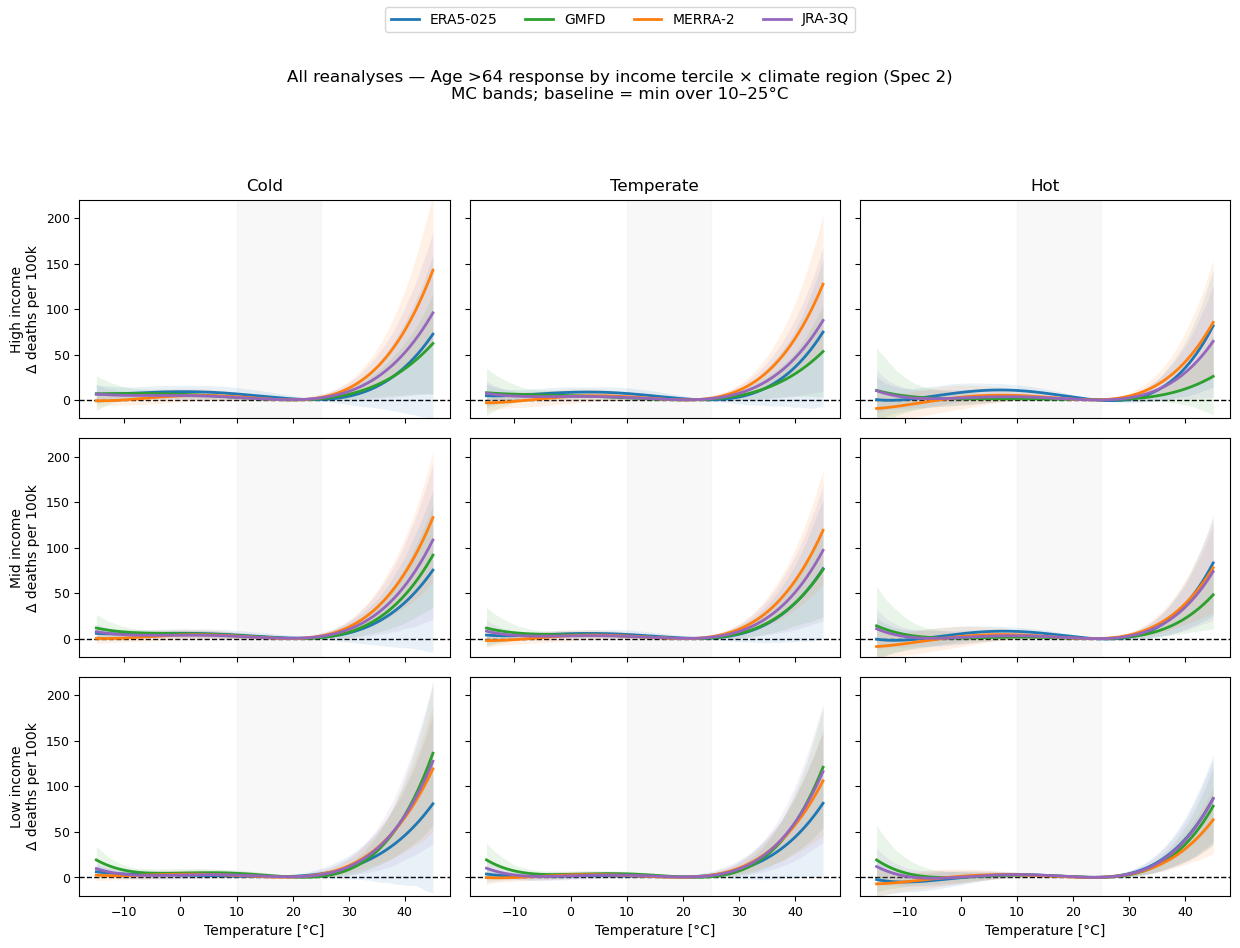

In [23]:
# ===== 3×3 OVERLAY: ERA5_025, GMFD, MERRA2, JRA_3Q (Age 65+) =====

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSVV_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv")
SPEC     = "spec2"
PRODUCTS = ["ERA5_025", "GMFD", "MERRA2", "JRA_3Q"]  # order in legend

# --- Per-product cell means (lr_tavg, log income) for the 9 panels ---
# Fill these from your prints per product (important: lr_tavg depends on product).
# I’ve prefilled GMFD from your message; copy in ERA5_025 / MERRA2 / JRA_3Q similarly.
def _cells_df(entries):
    return pd.DataFrame(entries, columns=["income_terc","temp_region","lr_mean","loginc"])

# Colors and labels per product
PROD_STYLE = {
    "ERA5_025": dict(label="ERA5-025", color="#1f77b4"),
    "GMFD":     dict(label="GMFD",     color="#2ca02c"),
    "MERRA2":   dict(label="MERRA-2",  color="#ff7f0e"),
    "JRA_3Q":   dict(label="JRA-3Q",   color="#9467bd"),
}

# Temps and normalization window (reuse your globals)
T = np.linspace(TMIN, TMAX, 800)
SL_MIN, SL_MAX = SLICE_MIN, SLICE_MAX
AGE_IDX = 2  # Old (65+)

# Load all CSVVs up front
GAMMAS = {}
for prod in PRODUCTS:
    csvv_path = CSVV_DIR / f"agespec_interaction_response_{SPEC}_{prod}.csvv"
    gm, gv = _read_gamma_and_vcv(csvv_path)
    GAMMAS[prod] = (gm, gv)

row_order = ["high","mid","low"]
col_order = ["cold","temperate","hot"]

fig, axes = plt.subplots(3, 3, figsize=(12.5, 9.5), sharex=True, sharey=True)
legend_handles = []

for i, inc in enumerate(row_order):
    for j, clim in enumerate(col_order):
        ax = axes[i, j]
        ax.axvspan(SL_MIN, SL_MAX, color="0.9", alpha=0.25, zorder=0)
        ax.axhline(0, color="k", ls="--", lw=1, zorder=1)

        for prod in PRODUCTS:
            # cell means for this product/panel
            df = CELL_MEANS[prod]
            r = df[(df.income_terc == inc) & (df.temp_region == clim)].iloc[0]

            # ---- choose LR: column-shared vs per-cell ----
            if USE_COLUMN_SHARED_LR:
                lr_for_panel = REGION_LR[(prod, clim)]
            else:
                lr_for_panel = float(r.lr_mean)

            # income always per-cell
            loginc_for_panel = float(r.loginc)

            gm, gv = GAMMAS[prod]
            y_mean, y_lo, y_hi = _mc_bands_for_city_age(
                T, SL_MIN, SL_MAX,
                lr_tavg=lr_for_panel,
                loggdppc=loginc_for_panel,
                gamma_mean=gm, gamma_vcv=gv,
                age_index=AGE_IDX,
                n_draws=600,
                rng=np.random.default_rng(123),
            )

            style = PROD_STYLE[prod]
            (ln,) = ax.plot(T, y_mean, lw=2.0, **style, zorder=3)
            ax.fill_between(T, y_lo, y_hi, alpha=0.10, color=style["color"], linewidth=0, zorder=2)

            if i == 0 and j == 0:
                legend_handles.append(ln)

        if i == 0: ax.set_title(clim.capitalize())
        if j == 0: ax.set_ylabel(f"{inc.capitalize()} income\nΔ deaths per 100k")

for ax in axes[-1, :]:
    ax.set_xlabel("Temperature [°C]")

for ax in axes.flat:
    ax.set_ylim(-20, 220)
    ax.set_yticks([0,50,100,150,200])
    ax.tick_params(labelsize=9)

fig.subplots_adjust(top=0.84)
fig.legend(handles=legend_handles, labels=[PROD_STYLE[p]["label"] for p in PRODUCTS],
           loc="upper center", ncol=len(PRODUCTS), frameon=True, fontsize=10)

fig.suptitle("All reanalyses — Age >64 response by income tercile × climate region (Spec 2)\nMC bands; baseline = min over 10–25°C", y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()


In [1]:
import pandas as pd, numpy as np
from pathlib import Path

bins_dir = Path("/user/ab5405/summeraliaclimate/code/regressions/bins")
gmfd_path = f"/user/ab5405/summeraliaclimate/code/regressions/prep_panels/global_mortality_panel_public_GMFD.dta"

labels = pd.read_csv(bins_dir / "gmfd_bins_labels.csv", dtype={"adm2_id":"string"})
usecols = ["adm2_id","year","agegroup","population",
           "lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
df = pd.read_stata(gmfd_path, columns=usecols)
df = df[(df["year"]==2010)&(df["agegroup"]=="65+")]
df["adm2_id"] = df["adm2_id"].astype(str)

merged = df.merge(labels, on="adm2_id", how="left")
